<a id='top'></a>
<h1>PISM paleo data to zarr </h1>

***Transformation of data from Antarctic Ice Sheet glacial cycle experiments***

(c) 2020 by Torsten Albrecht (torsten.albrecht@pik-potsdam.de) | Potsdam Institute for Climate Impact Research (PIK)

inspired by on https://github.com/ldeo-glaciology/pangeo-bedmachine


**data:** Albrecht, Torsten (2019): PISM parameter ensemble analysis of Antarctic Ice Sheet glacial cycle simulations. PANGAEA, https://doi.pangaea.de/10.1594/PANGAEA.909728

The analysis is based on the scoring scheme with respect to modern and paleo data (https://doi.org/10.5281/zenodo.3585118).

<a id='overview'></a>
<h2>Overview of PISM settings</h2>

**Forcings and initial values** see https://github.com/pism/pism-ais

*Initial ice configuration:* Bedmap2, Fretwell et al., 2013

*Atmosphere:* Racmo v.2.3p2, Wessem et al., 2017

*Ocean:* Schmidtko et al. 2014, Zwally et al., 2012

*Basal Heatflux:* Martos et al., 2017



**Key (default) parameters**
```

ecalv             = 1e17 m s
hcalv             = 75 m
gammaT            = 1.0e-5 m s-1
overturning_coeff = 0.8e6 m3 s-1
essa              = 0.6
till_effo         = 0.04
till_dec          = 1 mm yr-1

ppq               = 0.75
esia              = 2.0
pscale            = 7 % K-1
visc              = 0.5e21 Pa s

```

**Ensemble parameter space**
```
ppq    = [0.25, 0.5, 0.75, 1.0]
esia   = [1.0, 2.0, 4.0, 7.0]
pscale = [0.02, 0.05, 0.07, 0.1] K-1
visc   = [1e+20, 5e+20, 2.5e+21, 1e+22] Pa s

```

**Run length**

130,000 years

**Horizontal grid resolution**

16000 m x 16000 m (381 x 381 grid points as in initMIP)

<br>
<div class="alert alert-block alert-warning">**PISM code version**
<br><br>
PISMR (basic evolution run mode stable v1.0-123-gf2e24e8 committed by Torsten Albrecht on 2018-01-22<br>
see branch <a href="https://github.com/talbrecht/pism_pik/commits/pism_pik_1.0">https://github.com/talbrecht/pism_pik/commits/pism_pik_1.0</a>,<br>
see release <a href="https://github.com/talbrecht/pism_pik/releases/tag/v1.0-paleo-ensemble">https://github.com/talbrecht/pism_pik/releases/tag/v1.0-paleo-ensemble</a>,<br>
published in <a href="https://doi.org/10.5281/zenodo.3574033">https://doi.org/10.5281/zenodo.3574033</a><br>
</div>

<a id='settings'></a>
<h2>Notebook settings</h2>

In [1]:
%%javascript
// hide presentation toolbar
$('.nbp-app-bar').toggle()

// disable autoscroll in output cells
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Make the notebook cells take almost all available width

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
# More info:
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser

<a id='constants'></a>
<h2>PISM constants and pathes</h2>

In [3]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

#import matplotlib.pylab as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
import gcsfs
import json
import cftime
import copy, os
from tqdm.notebook import tqdm   # progress bar
import datetime

### set constants
seconds_per_year = 365.0*24.0*60.0*60.0
rhoi  = 910.0
rhosw = 1028.0
rhofw = 1.0e3
km3_to_msle = 361.0e3*rhosw/rhoi

resolution=16

### PISM mask values
mfl=3 #floating
moc=4 #open ocean (sea ice not considered!)
mgr=2 #grounded ice

# Modify the trunk according to your local file system, where the data are saved to
trunk = "/p/tmp/albrecht/paleo_ensemble/"

datapath = trunk+"datapub/model_data/"
ensembleout = datapath+"aggregated_data/"

# Just to add surface elevation history, which is not in the published data yet
fullensemblepath = '/p/projects/pism_fesom/pism_paleo_d1'
add_usurf = False
add_topg_lgm = True

gsurl = "gs://ldeo-glaciology/paleo_ensemble/"

#score_names = ["TOTAL","TOTE","TOTI","TOTDH","TOTVEL","TOTGL","TOTUPL","TROUGH","ELEV","EXT"]

xr.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
python-bits: 64
OS: Linux
OS-release: 4.4.162-94.72-default
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8
libhdf5: 1.10.4
libnetcdf: 4.7.3

xarray: 0.16.1
pandas: 1.1.4
numpy: 1.19.4
scipy: 1.5.2
netCDF4: 1.5.3
pydap: None
h5netcdf: None
h5py: None
Nio: None
zarr: 2.5.0
cftime: 1.3.0
nc_time_axis: None
PseudoNetCDF: None
rasterio: None
cfgrib: None
iris: None
bottleneck: None
dask: 2.30.0
distributed: 2.30.1
matplotlib: 3.3.3
cartopy: 0.18.0
seaborn: None
numbagg: None
pint: None
setuptools: 50.3.0.post20201006
pip: 20.2.4
conda: None
pytest: None
IPython: 7.18.1
sphinx: None


<a id='scores'></a>
<h2>Read the ensemble paramters and scores</h2>

In [4]:
def get_parameter_values_for_ensemble(pfile):

    param_dict={}
    param_ens={}
    param_names=[]
    param_diff={}

    with open(pfile) as f:
      for l,line in enumerate(f.readlines()):

        param_vals={}
        params=line.rstrip('\n').split('"')

        #header with parameter names
        if l==0:
          for pn in params[0].split(' '):
              param_names.append(pn)

        else:
          ensmem=str(params[1].split(' ')[1])
          for pi,pn in enumerate(params[2].split(' ')):
              try:
                param_vals[param_names[pi]]=np.float(pn)
              except:
                "no paramter val"
              if param_names[pi]=='visc':
                param_vals[param_names[pi]]=np.float(pn)*1e21

          if l==1:
            param_diff=param_vals
          else:
            for pn,pval in param_vals.items():
              if pval!=param_diff[pn]:

                if pn not in param_dict.keys():
                  param_dict.setdefault(pn, [])

                if pval not in param_dict[pn]:
                  param_dict[pn].append(pval)

          param_ens[ensmem]=param_vals

    #add parameter vals from first run
    for pn,pvals in param_dict.items():
      param_dict[pn].insert(0,param_diff[pn])

    return (param_ens,param_dict)

##########################################################################################
runfile = ensembleout+"pism1.0_paleo06_6000.csv"
ens_par,par_space = get_parameter_values_for_ensemble(runfile)


statfile = ensembleout+"le_all06_16km.txt"

ens_scr={}
with open(statfile) as fp:
    for line in fp:
        scorenum=line.split(",")[0]
        scores=[]
        for i,score in enumerate(line.split(",")):
          if i>0:
            scores.append(np.float(score.rstrip("\n"))) 
        ens_scr[scorenum]=scores
        
best_scores = [ k for k, v in sorted(ens_scr.items(), key=lambda l: l[1], reverse=True)]
print(best_scores[0:3])

['6165', '6245', '6242']


<a id='pismfiles'></a>
<h2>Collect all ensemble result files in dict</h2>

In [5]:

ensemble = dict.fromkeys(["name","exp_dir","exp_name","start_id","end_id"])
model_files = ["present","extra","timeseries","snapshots"]

ensemble['name'] = 'paleo_ensemble'
ensemble['exp_dir'] = datapath
ensemble['exp_name'] = "pism1.0_paleo06"
ensemble['start_id'] = 6000
ensemble['end_id'] = 6255
# best fit/score reference: 6165

ensemble['notes'] = "PISM paleo ensemble data as in https://doi.org/10.1594/PANGAEA.909728"
ensemble['contact'] = "albrecht@pik-potsdam.de"
ensemble['date'] = datetime.date.today().strftime('%Y-%m-%d')
ensemble['parameter_space'] = par_space
ensemble['code'] = 'https://github.com/ldeo-glaciology/pangeo-pismpaleo'

run = dict.fromkeys(["proj_dir","scores","file_path","parameter_values"]) #FIXME: fill notes with parameters and scores 
runs = {}
ids  = []
for id in np.arange(ensemble['start_id'],ensemble['end_id']):
    runs[id]=copy.deepcopy(run)
    ids.append(id)
    

for k, v in tqdm(runs.items(),total=len(runs)):
        #print(k,v)
        runs[k]['proj_dir'] = os.path.join(ensemble['exp_dir'], ensemble['exp_name']+"_"+str(k))
        runs[k]['file_path'] = dict.fromkeys(model_files,"")
        
        present_file = "paleo.nc"
        runs[k]['file_path']['present'] = [os.path.join(runs[k]['proj_dir'], present_file)]
        
        snap_files = ["snapshots_-20000.000.nc","snapshots_-15000.000.nc","snapshots_-10000.000.nc","snapshots_-5000.000.nc",present_file]
        runs[k]['file_path']['snapshots'] = []
        for sf in snap_files:
            if add_topg_lgm:
                runs[k]['file_path']['snapshots'].append(os.path.join(fullensemblepath, ensemble['exp_name']+"_"+str(k), sf))
            else:
                runs[k]['file_path']['snapshots'].append(os.path.join(runs[k]['proj_dir'], sf))
        
        mask_file = "extra_paleo_mask.nc"
        runs[k]['file_path']['extra'] = [os.path.join(runs[k]['proj_dir'], mask_file)]   
        if add_usurf:
            usurf_file = 'extra_paleo.nc'
            runs[k]['file_path']['extra'] = [os.path.join(fullensemblepath, ensemble['exp_name']+"_"+str(k), usurf_file)]
        
        time_file = "timeseries.nc"
        runs[k]['file_path']['timeseries'] = [os.path.join(runs[k]['proj_dir'], time_file)]
        
        runs[k]['parameter_values'] = ens_par[str(k)]
        runs[k]['scores'] = ens_scr[str(k)]
           


<a id='xarrayload'></a>
<h2>Load PISM netCDF files to xarrays </h2>

In [6]:

variables={'snapshots':['thk','mask'],
           'present':['thk','mask','topg','usurf','velsurf_mag','dbdt'],
           'extra':['mask'],
           'lgm':['thk','mask','topg','usurf'],
           'timeseries':['slvol','ice_volume_glacierized','time']}

if add_usurf:
    variables['extra'].append('usurf')
    
if add_topg_lgm:
    variables['snapshots'] = variables['lgm']

alldatasets=[]
# iterate over datasets
for mf in tqdm(model_files):
    print(mf)
    datasets=[]
    
    # iterate over ensemble members
    for k in sorted(runs.keys()):
        dataset=[]
        if runs[k]['file_path'][mf]:
            for pismf in runs[k]['file_path'][mf]:
              #with xr.set_options(enable_cftimeindex=True):
                with xr.open_dataset(pismf, decode_cf=True,decode_times=False) as ds: #decode_timedelta=True,use_cftime=True
                    
                    ds = ds.get(variables[mf])
                    
                    # convert to years (or better ka BP?)
                    ds["time"]=(['time'], ds["time"].time/seconds_per_year)
                    
                    # add ensemble id as dim
                    ds = ds.expand_dims('id')
                    ds["id"] =(["id"], [k])                    
                    
                    # add total ensemble scores for each ensemble member
                    ds["score"]=(['id'],  [ens_scr[str(k)][0]])
                    ds["score"].attrs['long_name']  = "Normalized total ensemble score according to nine data types"
                    
                    ds["par_ppq"] =(['id'],  [runs[k]['parameter_values']['ppq']])
                    ds["par_esia"]=(['id'],  [runs[k]['parameter_values']['sia_e']])
                    ds["par_prec"]=(['id'],  [runs[k]['parameter_values']['prec']])
                    ds["par_visc"]=(['id'],  [runs[k]['parameter_values']['visc']])
                    
                    ds["par_prec"].attrs['units'] = "K-1"
                    ds["par_visc"].attrs['units'] = "Pa s"
                    
                    ds["par_ppq"].attrs['long_name']  = "Pseudo plastic sliding exponent"
                    ds["par_esia"].attrs['long_name'] = "Shallow ice approximation enhancement factor"
                    ds["par_prec"].attrs['long_name'] = 'Precipitation scaling with external temperature forcing'
                    ds["par_visc"].attrs['long_name'] = "Upper mantle viscosity in Lingle-Clark bed deformation model"
                    
                    dataset.append(ds)
                    
        concat_time = xr.concat(dataset, dim='time') #,data_vars=list([u'mask',u'thk'])
        datasets.append(concat_time)

    combined = xr.concat(datasets, dim='id')
    combined.attrs['parameter_space'] = str(par_space)
    combined.attrs['history']='' #FIXME: How to delete attributes?
    combined.attrs['date'] = ensemble['date']
    combined.attrs['contact'] = ensemble['contact']
    combined.attrs['notes'] = ensemble['notes']
    combined.attrs['code'] = ensemble['code']
    
    alldatasets.append(combined)


present
extra
timeseries
snapshots



In [7]:
#alldatasets[0]
alldatasets[1]

<xarray.Dataset>
Dimensions:   (id: 255, time: 125, x: 381, y: 381)
Coordinates:
  * time      (time) float64 -1.24e+05 -1.23e+05 -1.22e+05 ... -2e+03 -1e+03 0.0
  * x         (x) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * y         (y) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * id        (id) int64 6000 6001 6002 6003 6004 ... 6250 6251 6252 6253 6254
Data variables:
    mask      (id, time, y, x) int8 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4
    score     (time, id) float64 2.868e-05 7.436e-05 ... 0.001041 0.0001997
    par_ppq   (time, id) float64 0.25 0.25 0.25 0.25 0.25 ... 1.0 1.0 1.0 1.0
    par_esia  (time, id) float64 1.0 1.0 1.0 1.0 2.0 2.0 ... 4.0 4.0 7.0 7.0 7.0
    par_prec  (time, id) float64 0.02 0.02 0.02 0.02 0.02 ... 0.1 0.1 0.1 0.1
    par_visc  (time, id) float64 1e+20 5e+20 2.5e+21 ... 1e+20 5e+20 2.5e+21
Attributes:
    command:           /p/tmp/albrecht/pism18/pismOut/pism_paleo/pism1.0_pale...
    NCO:              4.6.8
    history:          
    parameter_space:  {'visc': [1e+20, 5e+20, 2.5e+21, 1e+22], 'sia_e': [1.0,...
    date:             2020-12-07
    contact:          albrecht@pik-potsdam.de
    notes:            PISM paleo ensemble data as in https://doi.org/10.1594/...
    code:             https://github.com/ldeo-glaciology/pangeo-pismpaleo

<a id='xarraytozarr'></a>
<h2>Export to Zarr Format</h2>

In [8]:
for mi,mf in enumerate(tqdm(model_files)):
    print(mi,mf)
    zarr_present_folder = trunk+"pangeo/zarr/"+mf
    alldatasets[mi].to_zarr(zarr_present_folder, consolidated=True, mode='w')


0 present
1 extra
2 timeseries
3 snapshots



**size of zarr folders:**
 
 - 361M	extra
 - 823M	present
 - 522M	timeseries
 - 2.3G	snapshots

<a id='addtoken'></a>
<h2>Add token from LDEO which enables to write to bucket </h2>


In [9]:
#print(gcsfs.__version__)
with open('../../tokens/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token, access='read_write')

<a id='writezarr'></a>
<h2>Save zarr to bucket </h2>


In [10]:
for mi,mf in enumerate(tqdm(model_files)):
    print(mi,mf)
    #alldatasets[mi] = alldatasets[mi].drop('mapping')   # remove the variable.
    mapper = gcs.get_mapper(gsurl+mf+'.zarr')
    alldatasets[mi].to_zarr(mapper, consolidated=True, mode='w')

0 present
1 extra
2 timeseries
3 snapshots



<a id='checkzarr'></a>
<h2>Reload the zarr and compare with original </h2>


In [17]:
%%time
present_reloaded = xr.open_zarr(gcs.get_mapper(gsurl+'present.zarr'))  
present_reloaded.identical(alldatasets[0])

CPU times: user 16.1 s, sys: 1.72 s, total: 17.8 s
Wall time: 44.5 s


True

In [12]:
#extra_reloaded = xr.open_zarr(gcs.get_mapper(gsurl+'extra.zarr'))  
#extra_reloaded.identical(alldatasets[1])

In [13]:
timeseries_reloaded = xr.open_zarr(gcs.get_mapper(gsurl+'timeseries.zarr'))  
timeseries_reloaded.identical(alldatasets[2])

True

In [14]:
snapshots_reloaded = xr.open_zarr(gcs.get_mapper(gsurl+'snapshots.zarr'))  
snapshots_reloaded.identical(alldatasets[3])

True

In [15]:
# display metadata
present_reloaded

<xarray.Dataset>
Dimensions:      (id: 255, time: 1, x: 381, y: 381)
Coordinates:
  * id           (id) int64 6000 6001 6002 6003 6004 ... 6251 6252 6253 6254
    lat          (y, x) float64 dask.array<chunksize=(191, 191), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(191, 191), meta=np.ndarray>
  * time         (time) float64 50.0
  * x            (x) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
  * y            (y) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Data variables:
    dbdt         (id, time, y, x) float64 dask.array<chunksize=(32, 1, 48, 96), meta=np.ndarray>
    mask         (id, time, y, x) int8 dask.array<chunksize=(64, 1, 96, 96), meta=np.ndarray>
    par_esia     (time, id) float64 dask.array<chunksize=(1, 255), meta=np.ndarray>
    par_ppq      (time, id) float64 dask.array<chunksize=(1, 255), meta=np.ndarray>
    par_prec     (time, id) float64 dask.array<chunksize=(1, 255), meta=np.ndarray>
    par_visc     (time, id) float64 dask.array<chunksize=(1, 255), meta=np.ndarray>
    score        (time, id) float64 dask.array<chunksize=(1, 255), meta=np.ndarray>
    thk          (id, time, y, x) float64 dask.array<chunksize=(32, 1, 48, 96), meta=np.ndarray>
    topg         (id, time, y, x) float64 dask.array<chunksize=(32, 1, 48, 96), meta=np.ndarray>
    usurf        (id, time, y, x) float32 dask.array<chunksize=(32, 1, 96, 96), meta=np.ndarray>
    velsurf_mag  (id, time, y, x) float32 dask.array<chunksize=(32, 1, 96, 96), meta=np.ndarray>
Attributes:
    NCO:              4.6.8
    code:             https://github.com/ldeo-glaciology/pangeo-pismpaleo
    command:           /p/tmp/albrecht/pism18/pismOut/pism_paleo/pism1.0_pale...
    contact:          albrecht@pik-potsdam.de
    date:             2020-12-07
    history:          
    notes:            PISM paleo ensemble data as in https://doi.org/10.1594/...
    parameter_space:  {'visc': [1e+20, 5e+20, 2.5e+21, 1e+22], 'sia_e': [1.0,...

<a id='testplot'></a>
<h2>Do some simple plot</h2>

11


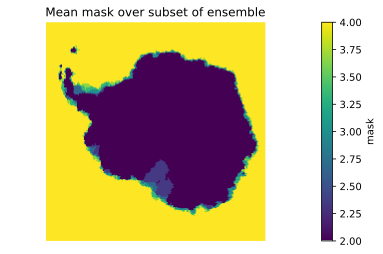

In [16]:
import matplotlib.pylab as plt

#selected_states = alldatasets[0].isel(id=slice(0,10))
selected_states = present_reloaded.isel(id=slice(0,10))
print(len(selected_states))

subsel = selected_states.where(selected_states.par_visc==5e+20).squeeze(dim="time")

subsel.mask.mean(dim='id').plot.imshow()
#selected_states.mask.plot(levels=[2, 2.25, 2.5 ,2.75 , 3, 4])


plt.title("Mean mask over subset of ensemble")
plt.ylabel("y in m")
plt.xlabel("x in m")
plt.tight_layout()
plt.axis("equal")
plt.axis("off")
plt.draw()